In [1]:
from bertopic import BERTopic

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 

import warnings
from numba import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, config
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings("ignore", category=NumbaPendingDeprecationWarning)
config.THREADING_LAYER = 'threadsafe'

from sklearn.preprocessing import MinMaxScaler
from umap import UMAP
from sklearn.cluster import DBSCAN

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words = set(ENGLISH_STOP_WORDS)
stop_words.add('said')
ENGLISH_STOP_WORDS = frozenset(stop_words)

from collections import defaultdict
import re
import pickle

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 100)

import plotly.graph_objects as go
import plotly.io as pio
from typing import List, Union


### Loading pulled Nature data (67k publications from 2005-2022):

In [3]:
df = pd.read_csv('data/nature__2005-09-01_2022-12-31.csv')

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
pd.set_option('max_colwidth', None)

### Cleaning up the dataframe:

In [11]:
df

,superscript,dc:publisher,journalid,xhtml:head,prism:number,openaccess,dc:language,prism:genre,citationref,prism:startingpage,prism:publicationdate,p,prism:contenttype,xhtml:body,prism:endingpage,prism:volume,prism:doi,dc:identifier,prism:url,dc:subject,pam:article,prism:publicationname,prism:issn,dc:title,prism:copyright,h1,dc:creator
0,"[<superscript><citationref additionalcitationids=""CR2"" citationid=""CR1"">1</citationref>–<citatio...",[<dc:publisher>Nature</dc:publisher>],[<journalid>41586</journalid>],[<xhtml:head>\n<pam:article><prism:contenttype>Article</prism:contenttype><dc:identifier>doi:10....,[<prism:number>7978</prism:number>],[<openaccess>true</openaccess>],[<dc:language>en</dc:language>],"[<prism:genre>OriginalPaper</prism:genre>, <prism:genre>Article</prism:genre>]","[<citationref additionalcitationids=""CR2"" citationid=""CR1"">1</citationref>, <citationref citatio...",[<prism:startingpage>365</prism:startingpage>],[<prism:publicationdate>2023-09-14</prism:publicationdate>],[<p>Self-organizing neural organoids grown from pluripotent stem cells<superscript><citationref ...,[<prism:contenttype>Article</prism:contenttype>],[<xhtml:body><h1>Abstract</h1><p>Self-organizing neural organoids grown from pluripotent stem ce...,[<prism:endingpage>372</prism:endingpage>],[<prism:volume>621</prism:volume>],[<prism:doi>10.1038/s41586-022-05279-8</prism:doi>],[<dc:identifier>doi:10.1038/s41586-022-05279-8</dc:identifier>],[<prism:url>http://dx.doi.org/10.1038/s41586-022-05279-8</prism:url>],"[<dc:subject>Science, Humanities and Social Sciences, multidisciplinary</dc:subject>, <dc:subjec...",[<pam:article><prism:contenttype>Article</prism:contenttype><dc:identifier>doi:10.1038/s41586-02...,[<prism:publicationname>Nature</prism:publicationname>],[<prism:issn>1476-4687</prism:issn>],[<dc:title>Inferring and perturbing cell fate regulomes in human brain organoids</dc:title>],[<prism:copyright>©2022 The Author(s)</prism:copyright>],[<h1>Abstract</h1>],"[<dc:creator>Fleck, Jonas Simon</dc:creator>, <dc:creator>Jansen, Sophie Martina Johanna</dc:cre..."
1,"[<superscript><citationref citationid=""CR1"">1</citationref></superscript>]",[<dc:publisher>Nature</dc:publisher>],[<journalid>41586</journalid>],[<xhtml:head>\n<pam:article><prism:contenttype>Article</prism:contenttype><dc:identifier>doi:10....,[<prism:number>7962</prism:number>],[<openaccess>false</openaccess>],[<dc:language>en</dc:language>],"[<prism:genre>OriginalPaper</prism:genre>, <prism:genre>Article</prism:genre>]","[<citationref citationid=""CR1"">1</citationref>]",[<prism:startingpage>792</prism:startingpage>],[<prism:publicationdate>2023-05-25</prism:publicationdate>],"[<p>In mice, only the zygotes and blastomeres from 2-cell embryos are authentic totipotent stem ...",[<prism:contenttype>Article</prism:contenttype>],"[<xhtml:body><h1>Abstract</h1><p>In mice, only the zygotes and blastomeres from 2-cell embryos a...",[<prism:endingpage>797</prism:endingpage>],[<prism:volume>617</prism:volume>],[<prism:doi>10.1038/s41586-022-04967-9</prism:doi>],[<dc:identifier>doi:10.1038/s41586-022-04967-9</dc:identifier>],[<prism:url>http://dx.doi.org/10.1038/s41586-022-04967-9</prism:url>],"[<dc:subject>Science, Humanities and Social Sciences, multidisciplinary</dc:subject>, <dc:subjec...",[<pam:article><prism:contenttype>Article</prism:contenttype><dc:identifier>doi:10.1038/s41586-02...,[<prism:publicationname>Nature</prism:publicationname>],[<prism:issn>1476-4687</prism:issn>],[<dc:title>Induction of mouse totipotent stem cells by a defined chemical cocktail</dc:title>],"[<prism:copyright>©2022 The Author(s), under exclusive licence to Springer Nature Limited</prism...",[<h1>Abstract</h1>],"[<dc:creator>Hu, Yanyan</dc:creator>, <dc:creator>Yang, Yuanyuan</dc:creator>, <dc:creator>Tan, ..."
2,"[<superscript><citationref additionalcitationids=""CR2"" citationid=""CR1"">1</citationref>–<citatio...",[<dc:publisher>Nature</dc:publisher>],[<journalid>41586</journalid>],[<xhtml:head

In [5]:
df.columns

Index(['superscript', 'dc:publisher', 'journalid', 'xhtml:head',
       'prism:number', 'openaccess', 'dc:language', 'prism:genre',
       'citationref', 'prism:startingpage', 'prism:publicationdate', 'p',
       'prism:contenttype', 'xhtml:body', 'prism:endingpage', 'prism:volume',
       'prism:doi', 'dc:identifier', 'prism:url', 'dc:subject', 'pam:article',
       'prism:publicationname', 'prism:issn', 'dc:title', 'prism:copyright',
       'h1', 'dc:creator'],
      dtype='object')

In [6]:
df_nature = df.copy()

### Extracting the date:

In [7]:
df_nature['date'] = df['prism:publicationdate'].str.extract(r'(\d{4}-\d{2}-\d{2})')

 The regular expression r'(\d{4}-\d{2}-\d{2})' is used to match and extract the date pattern YYYY-MM-DD from the <prism:publicationdate> tags.

In [8]:
# Convert the extracted date to datetime if needed
df_nature['date'] = pd.to_datetime(df_nature['date'])

In [9]:
df_nature['date']

0       2023-09-14
1       2023-05-25
2       2023-03-23
3       2023-03-02
4       2023-03-02
           ...    
67513   2005-09-01
67514   2005-09-01
67515   2005-09-01
67516   2005-09-01
67517   2005-09-01
Name: date, Length: 67518, dtype: datetime64[ns]

### Extracting title:

In [10]:
df_nature['title'] = df_nature['dc:title'].str.extract(r'<dc:title>(.*?)</dc:title>')[0]

The regular expression <dc:title>(.*?)</dc:title> is used to match and extract the text between the <dc:title> tags. The (.*?) part is a non-greedy capture group that captures everything between the tags.

A non-greedy capture group (also known as a non-greedy quantifier) is a regular expression construct that specifies that a particular part of the pattern should match as little as possible while still allowing the overall pattern to match successfully. In contrast, a greedy capture group matches as much as possible.

    Greedy Capture Group: A greedy capture group is denoted by * or + after a regular expression element. For example, .* is a greedy expression that matches zero or more occurrences of any character.
        In the string "abcabc", the greedy expression .* would match the entire string because it's trying to consume as many characters as possible.

    Non-Greedy Capture Group: A non-greedy capture group is denoted by adding ? after the * or + quantifier. For example, .*? is a non-greedy expression.
        In the same string "abcabc", the non-greedy expression .*? would match only the first "abc" because it tries to match as little as possible while still allowing the overall pattern to match.

Non-greedy quantifiers are particularly useful when you want to match the shortest possible substring that satisfies a pattern. They are often used when working with HTML or XML data to extract text between tags,

In [11]:
df_nature['title']

0                Inferring and perturbing cell fate regulomes in human brain organoids
1              Induction of mouse totipotent stem cells by a defined chemical cocktail
2        Non-viral precision T cell receptor replacement for personalized cell therapy
3             Active eosinophils regulate host defence and immune responses in colitis
4                FXR inhibition may protect from SARS-CoV-2 infection by reducing ACE2
                                             ...                                      
67513                                     British duo probes origin of mad cow disease
67514                                         Spaghetti filters cleanse water supplies
67515                                                           Aerobot aims for Titan
67516                                                           Expression of interest
67517                                                                Highlight: Vienna
Name: title, Length: 67518, dtype: object

### Extracting abstract:

The abtracts are in the column 'p':

In [12]:
df['p']

0                                                                                                                                                                                                                                                           [<p>Self-organizing neural organoids grown from pluripotent stem cells<superscript><citationref additionalcitationids="CR2" citationid="CR1">1</citationref>–<citationref citationid="CR3">3</citationref></superscript> combined with single-cell genomic technologies provide opportunities to examine gene regulatory networks underlying human brain development. Here we acquire single-cell transcriptome and accessible chromatin data over a dense time course in human organoids covering neuroepithelial formation, patterning, brain regionalization and neurogenesis, and identify temporally dynamic and brain-region-specific regulatory regions. We developed Pando—a flexible framework that incorporates multi-omic data and predictions of transcription-f

In [13]:
df_nature['abstract'] = df_nature['p'].str.extract(r'<p>(.*?)</p>')[0] 

In [14]:
df_nature['abstract']

0        Self-organizing neural organoids grown from pluripotent stem cells<superscript><citationref additionalcitationids="CR2" citationid="CR1">1</citationref>–<citationref citationid="CR3">3</citationref></superscript> combined with single-cell genomic technologies provide opportunities to examine gene regulatory networks underlying human brain development. Here we acquire single-cell transcriptome and accessible chromatin data over a dense time course in human organoids covering neuroepithelial formation, patterning, brain regionalization and neurogenesis, and identify temporally dynamic and brain-region-specific regulatory regions. We developed Pando—a flexible framework that incorporates multi-omic data and predictions of transcription-factor-binding sites to infer a global gene regulatory network describing organoid development. We use pooled genetic perturbation with single-cell transcriptome readout to assess transcription factor requirement for cell fate and state regulation 

Some crap between "<" and ">"  sometimes, needs to be removed:

In [15]:
# Remove everything between < and > using regular expressions
df['column_with_text'] = df['column_with_text'].str.replace(r'<[^>]*>', '')

KeyError: 'column_with_text'

Does not work like this.

By setting regex=True, it is ensured that the pattern is treated as a regular expression, and it should work for HTML entities:

In [16]:
# Remove the <superscript>...</superscript> part using regular expressions
df_nature['abstract'] = df_nature['abstract'].str.replace(r'<[^>]*>', '', regex=True)

In [17]:
df_nature['abstract'].head(50)

0                                                                                                                                                                                                                                                                                                                                              Self-organizing neural organoids grown from pluripotent stem cells1–3 combined with single-cell genomic technologies provide opportunities to examine gene regulatory networks underlying human brain development. Here we acquire single-cell transcriptome and accessible chromatin data over a dense time course in human organoids covering neuroepithelial formation, patterning, brain regionalization and neurogenesis, and identify temporally dynamic and brain-region-specific regulatory regions. We developed Pando—a flexible framework that incorporates multi-omic data and predictions of transcription-factor-binding sites to infer a global gene regulatory network de

Yes, it did work

In [18]:
df_nature_clean = df_nature[['date', 'title', 'abstract']]

In [19]:
df_nature_clean

,date,title,abstract
0,2023-09-14,Inferring and perturbing cell fate regulomes in human brain organoids,"Self-organizing neural organoids grown from pluripotent stem cells1–3 combined with single-cell genomic technologies provide opportunities to examine gene regulatory networks underlying human brain development. Here we acquire single-cell transcriptome and accessible chromatin data over a dense time course in human organoids covering neuroepithelial formation, patterning, brain regionalization and neurogenesis, and identify temporally dynamic and brain-region-specific regulatory regions. We developed Pando—a flexible framework that incorporates multi-omic data and predictions of transcription-factor-binding sites to infer a global gene regulatory network describing organoid development. We use pooled genetic perturbation with single-cell transcriptome readout to assess transcription factor requirement for cell fate and state regulation in organoids. We find that certain factors regulate the abundance of cell fates, whereas other factors affect neuronal cell states after differentiation. We show that the transcription factor GLI3 is required for cortical fate establishment in humans, recapitulating previous research performed in mammalian model systems. We measure transcriptome and chromatin accessibility in normal or GLI3-perturbed cells and identify two distinct GLI3 regulomes that are central to telencephalic fate decisions: one regulating dorsoventral patterning with HES4/5 as direct GLI3 targets, and one controlling ganglionic eminence diversification later in development. Together, we provide a framework for how human model systems and single-cell technologies can be leveraged to reconstruct human developmental biology."
1,2023-05-25,Induction of mouse totipotent stem cells by a defined chemical cocktail,"In mice, only the zygotes and blastomeres from 2-cell embryos are authentic totipotent stem cells (TotiSCs) capable of producing all the differentiated cells in both embryonic and extraembryonic tissues and forming an entire organism1. However, it remains unknown whether and how totipotent stem cells can be established in vitro in the absence of germline cells. Here we demonstrate the induction and long-term maintenance of TotiSCs from mouse pluripotent stem cells using a combination of three small molecules: the retinoic acid analogue TTNPB, 1-azakenpaullone and the kinase blocker WS6. The resulting chemically induced totipotent stem cells (ciTotiSCs), resembled mouse totipotent 2-cell embryo cells at the transcriptome, epigenome and metabolome levels. In addition, ciTotiSCs exhibited bidirectional developmental potentials and were able to produce both embryonic and extraembryonic cells in vitro and in teratoma. Furthermore, following injection into 8-cell embryos, ciTotiSCs contributed to both embryonic and extraembryonic lineages with high efficiency. Our chemical approach to totipotent stem cell induction and maintenance provides a defined in vitro system for manipulating and developing understanding of the totipotent state and the development of multicellular organisms from non-germline cells."
2,2023-03-23,Non-viral precision T cell receptor replacement for personalized cell therapy,A first-in-human phase I clinical trial demonstrates the feasibility and safety of non-viral precision genome-engineering of a personalized adoptive cell transfer anticancer therapeutic.
3,2023-03-02,Active eosinophils regulate host defence and immune responses in colitis,"In the past decade, single-cell transcriptomics has helped to uncover new cell types and states and led to the construction of a cellular compendium of health and disease. Despite this progress, some difficult-to-sequence cells remain absent from tissue atlases. Eosinophils—elusive granulocytes that are implicated in a plethora of human pathologies1–5—are among these uncharted cell types. The heterogeneity of eosinophils and the gene programs that underpin their pl

Why is the abstract really short sometimes?

### Further cleaning the df_nature_clean dataframe:

Checking for duplicated rows:

In [21]:
df_nature_clean.duplicated().value_counts()

False    67500
True        18
Name: count, dtype: int64

In [22]:
# removing duplicates
df_nature_clean = df_nature_clean.drop_duplicates()

In [23]:
df_nature_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67500 entries, 0 to 67517
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      67500 non-null  datetime64[ns]
 1   title     67487 non-null  object        
 2   abstract  54990 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 2.1+ MB


In [24]:
df_nature_clean.isna().sum()

date            0
title          13
abstract    12510
dtype: int64

Many abstracts are missing 

Checking distribution of missing values:

<Axes: >

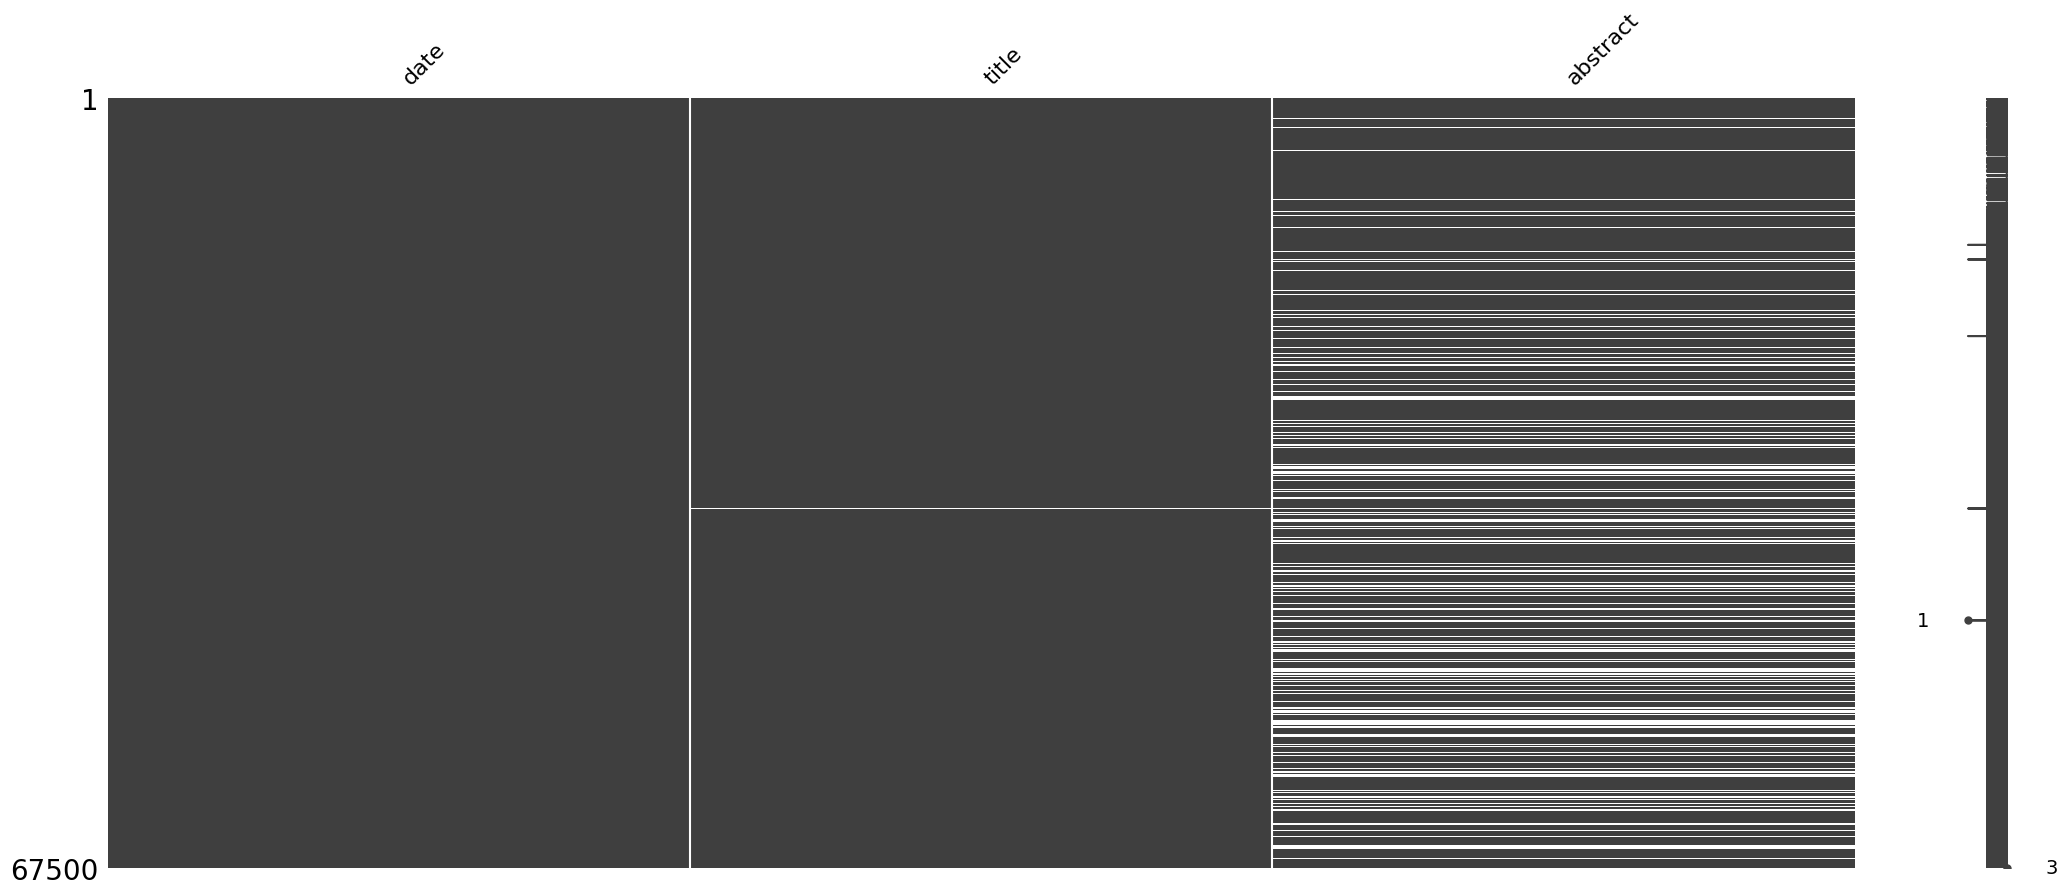

In [101]:
msno.matrix(df_nature_clean) 

Rows without abstract data are pretty useless, they will be dropped:

`.dropna()` | drops row if contains at least 1 NaN

In [25]:
df_nature_clean = df_nature_clean.dropna() 

In [26]:
df_nature_clean.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 54982 entries, 0 to 67516
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      54982 non-null  datetime64[ns]
 1   title     54982 non-null  object        
 2   abstract  54982 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


Changing object columns into category columns:

In [27]:
df_nature_clean['title'] = df_nature_clean['title'].astype('category')

In [28]:
df_nature_clean['abstract'] = df_nature_clean['abstract'].astype('category')

In [29]:
df_nature_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54982 entries, 0 to 67516
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      54982 non-null  datetime64[ns]
 1   title     54982 non-null  category      
 2   abstract  54982 non-null  category      
dtypes: category(2), datetime64[ns](1)
memory usage: 6.1 MB


In [30]:
df_nature_clean.to_csv('df_nature_clean.csv', index=False)

## Using BERTopic

First shot with 100 rows:

In [112]:
df_nature_clean_100 = df_nature_clean.head(100)

In [113]:
df_nature_clean_100 .info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 107
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      100 non-null    datetime64[ns]
 1   title     100 non-null    category      
 2   abstract  100 non-null    category      
dtypes: category(2), datetime64[ns](1)
memory usage: 4.8 MB


Removing stop words:

In [126]:
def clean_text(row):
    # Combine title and text
    combined_text = row['title'] + '. ' + row['abstract']
    # Tokenize and remove stopwords
    cleaned_tokens = [word for word in combined_text.split() if word.lower() not in ENGLISH_STOP_WORDS]
    return ' '.join(cleaned_tokens) 

df_nature_clean_100['text_clean'] = df_nature_clean_100.apply(clean_text, axis=1)

In [127]:
df_nature_clean_100['text_clean']

0                                                                                                                                                                       Inferring perturbing cell fate regulomes human brain organoids. Self-organizing neural organoids grown pluripotent stem cells1–3 combined single-cell genomic technologies provide opportunities examine gene regulatory networks underlying human brain development. acquire single-cell transcriptome accessible chromatin data dense time course human organoids covering neuroepithelial formation, patterning, brain regionalization neurogenesis, identify temporally dynamic brain-region-specific regulatory regions. developed Pando—a flexible framework incorporates multi-omic data predictions transcription-factor-binding sites infer global gene regulatory network describing organoid development. use pooled genetic perturbation single-cell transcriptome readout assess transcription factor requirement cell fate state regulation organo

In [128]:
docs = df_nature_clean_100['text_clean'].tolist()

In [140]:
model = BERTopic (language="english", n_gram_range = (1, 1), min_topic_size = 2)
topics, probs = model.fit_transform(docs)

model.visualize_topics()

In [141]:
topics, probs = model.fit_transform(docs)

In [142]:
len(topics), len(probs)

(100, 100)

In [143]:
df_nature_clean_100['topic'] = topics

In [144]:
df_nature_clean_100['topic'].nunique()

17

In [145]:
df_nature_clean_100['probs'] = probs

In [137]:
df_nature_clean_100

,date,title,abstract,topic,probs,text_clean
0,2023-09-14,Inferring and perturbing cell fate regulomes in human brain organoids,"Self-organizing neural organoids grown from pluripotent stem cells1–3 combined with single-cell genomic technologies provide opportunities to examine gene regulatory networks underlying human brain development. Here we acquire single-cell transcriptome and accessible chromatin data over a dense time course in human organoids covering neuroepithelial formation, patterning, brain regionalization and neurogenesis, and identify temporally dynamic and brain-region-specific regulatory regions. We developed Pando—a flexible framework that incorporates multi-omic data and predictions of transcription-factor-binding sites to infer a global gene regulatory network describing organoid development. We use pooled genetic perturbation with single-cell transcriptome readout to assess transcription factor requirement for cell fate and state regulation in organoids. We find that certain factors regulate the abundance of cell fates, whereas other factors affect neuronal cell states after differentiation. We show that the transcription factor GLI3 is required for cortical fate establishment in humans, recapitulating previous research performed in mammalian model systems. We measure transcriptome and chromatin accessibility in normal or GLI3-perturbed cells and identify two distinct GLI3 regulomes that are central to telencephalic fate decisions: one regulating dorsoventral patterning with HES4/5 as direct GLI3 targets, and one controlling ganglionic eminence diversification later in development. Together, we provide a framework for how human model systems and single-cell technologies can be leveraged to reconstruct human developmental biology.",1,1.000000,"Inferring perturbing cell fate regulomes human brain organoids. Self-organizing neural organoids grown pluripotent stem cells1–3 combined single-cell genomic technologies provide opportunities examine gene regulatory networks underlying human brain development. acquire single-cell transcriptome accessible chromatin data dense time course human organoids covering neuroepithelial formation, patterning, brain regionalization neurogenesis, identify temporally dynamic brain-region-specific regulatory regions. developed Pando—a flexible framework incorporates multi-omic data predictions transcription-factor-binding sites infer global gene regulatory network describing organoid development. use pooled genetic perturbation single-cell transcriptome readout assess transcription factor requirement cell fate state regulation organoids. certain factors regulate abundance cell fates, factors affect neuronal cell states differentiation. transcription factor GLI3 required cortical fate establishment humans, recapitulating previous research performed mammalian model systems. measure transcriptome chromatin accessibility normal GLI3-perturbed cells identify distinct GLI3 regulomes central telencephalic fate decisions: regulating dorsoventral patterning HES4/5 direct GLI3 targets, controlling ganglionic eminence diversification later development. Together, provide framework human model systems single-cell technologies leveraged reconstruct human developmental biology."
1,2023-05-25,Induction of mouse totipotent stem cells by a defined chemical cocktail,"In mice, only the zygotes and blastomeres from 2-cell embryos are authentic totipotent stem cells (TotiSCs) capable of producing all the differentiated cells in both embryonic and extraembryonic tissues and forming an entire organism1. However, it remains unknown whether and how totipotent stem cells can be established in vitro in the absence of germline cells. Here we demonstrate the induction and long-term maintenance of TotiSCs from mouse pluripotent stem cells using a combination of three small molecules: the retinoic acid analogue TTNPB, 1-azakenpaullone and the kinase blocker WS6. The resulting chemically induced totipotent stem c

In [146]:
model.get_topic_info()

Topic  Count                                               Name  \
0      -1      9          -1_eosinophils_phytohormone_spillover_nss   
1       0      8                         0_social_neurons_sc_cortex   
2       1      8                     1_building_maya_hints_bayesian   
3       2      8               2_cell_interactions_nlrp3_structures   
4       3      7               3_editor_letter_sessions_initiatives   
5       4      7         4_micrometres_field_atmospheres_atmosphere   
6       5      7                      5_tumour_cancer_p53_circadian   
7       6      7        6_covid19_discriminatory_attitudes_pandemic   
8       7      6                 7_children_years_childrens_malaria   
9       8      6             8_surface_light_perovskite_oxygenation   
10      9      6                    9_robinson_reviews_picks_andrew   
11     10      5                     10_cells_myelin_stem_senescent   
12     11      5               11_thymocyte_hybrids_paternal_cyclic   
13     12      4        12_sarscov2_antibodies_mutations_convergent   
14     13      3         13_segmentation_clock_somitogenesis_somite   
15     14      2  14_spermatogenesis_evolution_testis_spermatogenic   
16     15      2                    15_logged_forests_unlogged_baby   

                                                                                                         Representation  \
0                              [eosinophils, phytohormone, spillover, nss, science, immunity, nlr, pathogens, tsw, bat]   
1                                        [social, neurons, sc, cortex, reward, escape, shelter, coupling, rsp, circuit]   
2                                [building, maya, hints, bayesian, help, researchers, model, structures, ground, realm]   
3              [cell, interactions, nlrp3, structures, adhesion, proteins, conserved, transpososome, complex, assembly]   
4                     [editor, letter, sessions, initiatives, security, reconsider, overhaul, score, online, societies]   
5                           [micrometres, field, atmospheres, atmosphere, co2, carbon, models, science, magnetic, jwst]   
6                                 [tumour, cancer, p53, circadian, brd8, glioblastoma, network, expansions, cells, ca2]   
7      [covid19, discriminatory, attitudes, pandemic, unvaccinated, excess, deaths, vaccinated, individuals, countries]   
8                                [children, years, childrens, malaria, use, vaccine, health, traumatized, births, wait]   
9                            [surface, light, perovskite, oxygenation, solar, efficiency, bonds, ch, conversion, power]   
10                                      [robinson, reviews, picks, andrew, textbooks, books, brief, best, new, science]   
11                              [cells, myelin, stem, senescent, totipotent, clstn3, regeneration, ld, microglia, cell]   
12                          [thymocyte, hybrids, paternal, cyclic, radiation, rnadna, ionizing, exposure, calpl, rloop]   
13                [sarscov2, antibodies, mutations, convergent, infection, ace2, memory, resistance, ba5, nirmatrelvir]   
14             [segmentation, clock, somitogenesis, somite, human, pperk, axioloids, sequential, patterning, segmental]   
15  [spermatogenesis, evolution, testis, spermatogenic, molecular, mammalian, mammals, evolutionary, genes, expression]   
16                              [logged, forests, unlogged, baby, flows, entrances, fledglings, bird, forest, tropical]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

Looks good, now for all the data:

Removing stop words for all the data:

In [48]:
def clean_text(row):
    # Combine title and text
    combined_text = row['title'] + '. ' + row['abstract']
    # Tokenize and remove stopwords
    cleaned_tokens = [word for word in combined_text.split() if word.lower() not in ENGLISH_STOP_WORDS]
    return ' '.join(cleaned_tokens) 

df_nature_clean['text_clean'] = df_nature_clean.apply(clean_text, axis=1)

In [49]:
docs_2 = df_nature_clean['text_clean'].tolist()

In [149]:
topics, probs = model.fit_transform(docs_2)

In [150]:
model.save("nature_bertopic_2015_2020_min_topic_size_2")


c:\Users\49176\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [152]:
model.get_topic_info().head(20)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,18718,-1_galaxies_climate_carbon_star,"[galaxies, climate, carbon, star, land, stars, light, earth, channels, plus]","[Strongly correlated Chern insulators magic-angle twisted bilayer graphene. Interactions electrons topology energy bands create unusual quantum phases matter. topological electronic phases appear systems weak electron–electron interactions. instances topological phases emerge result strong interactions rare limited realized intense magnetic fields1. discovery flat electronic bands topological character magic-angle twisted bilayer graphene (MATBG) created unique opportunity search strongly correlated topological phases2–9. introduce local spectroscopic technique using scanning tunnelling microscope detect sequence topological insulators MATBG Chern numbers C = ±1, ±2 ±3, form near filling factors ±3, ±2 ±1 electrons moiré unit cell, respectively, stabilized modest magnetic fields. phases detected (C = +1) previously observed sublattice symmetry MATBG intentionally broken hexagonal boron nitride substrate, interactions having secondary role9. demonstrate strong electron–electron interactions produce previously observed phase, unexpected Chern insulating phases MATBG. sequence phases observe understood postulating strong correlations favour breaking time-reversal symmetry form Chern insulators stabilized weak magnetic fields. findings illustrate many-body correlations create topological phases moiré systems anticipated weakly interacting models., Trade-offs using European forests meet climate objectives. Paris Agreement promotes forest management pathway halting climate warming reduction carbon dioxide (CO2) emissions1. However, climate benefits carbon sequestration forest management reinforced, counteracted offset concurrent management-induced changes surface albedo, land-surface roughness, emissions biogenic volatile organic compounds, transpiration sensible heat flux2–4. Consequently, forest management offset CO2emissions halting global temperature rise. remains confirmed commonly proposed sustainable European forest-management portfolios comply Paris Agreement—that is, reduce growth rate atmospheric CO2, reduce radiative imbalance atmosphere, increase near-surface air temperature decrease precipitation end twenty-first century. portfolio management systems locally maximize carbon sink carbon sequestration, wood use product energy substitution reduces growth rate atmospheric CO2, does meet criteria. portfolios maximize carbon sink forest albedo pass one—different case—criterion. Managing European forests objective reducing near-surface air temperature, hand, reduce atmospheric CO2growth rate, meeting criteria. Trade-off unavoidable using European forests meet climate objectives. Furthermore, results demonstrate present-day forest cover sustained, additional climate benefits achieved forest management modest local, global. basis findings, argue Europe rely forest management mitigate climate change. modest climate effects changes forest management imply, however, adaptation future climate require large-scale changes species composition silvicultural systems Europe5,6, forests adapted climate change positive negative climate effects., dynamics molecular evolution 60,000 generations. outcomes evolution determined stochastic dynamical process governs mutations arise spread population. However, difficult observe dynamics directly long periods entire genomes. analyse dynamics molecular evolution experimental populations Escherichia coli, using whole-genome metagenomic sequencing hundred-generation intervals thousand generations. rate fitness gain declines time, molecular evolution characterized signatures rapid adaptation duration experiment, multiple beneficial variants simultaneously competing dominance population. Interactions ecological evolutionary processes play important role, long-term quasi-stable coexistence arises spontaneously populations, evolution

In [158]:
model.visualize_barchart(top_n_topics=20)

In [157]:
model.visualize_topics(top_n_topics=20)

Another try with a min_topic_size of 25:  

In [32]:
model_2 = BERTopic (language="english", n_gram_range = (1, 1), min_topic_size = 25)

In [160]:
topics, probs = model_2.fit_transform(docs_2)

In [161]:
model_2.save("nature_bertopic_2015_2020_min_topic_size_25")

c:\Users\49176\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [35]:
loaded_model = BERTopic.load("nature_bertopic_2015_2020_min_topic_size_25")

In [39]:
loaded_model['Topic']

TypeError: 'BERTopic' object is not subscriptable

In [41]:
# Get the topic information using the get_topics() method
topics = loaded_model.get_topics()

In [36]:
loaded_model.get_topic_info().head(20)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,21992,-1_cells_cancer_cell_human,"[cells, cancer, cell, human, new, research, gene, science, protein, development]","[gut microbiota associated immune cell dynamics humans. gut microbiota influences development1–3 homeostasis4–7 mammalian immune system, associated human inflammatory8 immune diseases9,10 responses immunotherapy11–14. Nevertheless, understanding gut bacteria modulate immune remains limited, particularly humans, difficulty direct experimentation makes inference challenging. study hundreds hospitalized—and closely monitored—patients cancer receiving haematopoietic cell transplantation recover chemotherapy stem-cell engraftment. aggressive treatment causes large shifts circulatory immune cell microbiota populations, enabling relationships studied simultaneously. Analysis observed daily changes circulating neutrophil, lymphocyte monocyte counts 10,000 longitudinal microbiota samples revealed consistent associations gut bacteria immune cell dynamics. High-resolution clinical metadata Bayesian inference allowed compare effects bacterial genera relation immunomodulatory medications, revealing considerable influence gut microbiota—together time—on systemic immune cell dynamics. analysis establishes quantifies link gut microbiota human immune system, implications microbiota-driven modulation immunity., High-resolution lineage tracking reveals travelling wave adaptation laboratory yeast. rapidly adapting asexual populations, including microbial pathogens viruses, numerous mutant lineages compete dominance population1–5. complex evolutionary dynamics determine outcomes adaptation, difficult observe directly. Previous studies used whole-genome sequencing follow molecular adaptation6–10; however, methods limited resolution microbial populations. introduce renewable barcoding observe evolutionary dynamics high resolution laboratory budding yeast. nested patterns interference hitchhiking low frequencies. events driven continuous appearance new mutations modify fates existing lineages reach substantial frequencies. observe distribution fitness population changes time, travelling wave adaptation predicted theory11–17. clonal competition creates dynamical ‘rich-get-richer’ effect: fitness advantages acquired early evolution drive clonal expansions, increase chances acquiring future mutations. However, less-fit lineages routinely leapfrog strains higher fitness. results demonstrate combination factors, accounted existing models evolutionary dynamics, critical determining rate, predictability molecular basis adaptation., NIH Somatic Cell Genome Editing program. reading writing human genome offers new opportunities improve human health. United States National Institutes Health (NIH) Somatic Cell Genome Editing (SCGE) Consortium aims accelerate development safer more-effective methods edit genomes disease-relevant somatic cells patients, tissues difficult reach. discuss consortium’s plans develop benchmark approaches induce measure genome modifications, define downstream functional consequences genome editing human cells. Central effort rigorous innovative approach requires validation technology third-party testing small large animals. New genome editors, delivery technologies methods tracking edited cells vivo, newly developed animal models human biological systems, assembled—along validated datasets—into SCGE Toolkit, disseminated widely biomedical research community. visualize toolkit—and knowledge generated applications—as means accelerate clinical development new therapies wide range conditions.]"
1,0,1303,0_covid_coronavirus_covid19_vaccine,"[covid, coronavirus, covid19, vaccine, pandemic, vaccines, daily, briefing, plus, sarscov2]","[Daily briefing: know vaccines long COVID. Vaccines reduce risk developing COVID-19 — studies disagree protective effect long COVID. Plus, lab-grown seafood coming table near AI-powered protein-folding predictions., Coronapod: Kids COVID vac

In [163]:
loaded_model.visualize_barchart(top_n_topics=20)

Time analysis:

In [43]:

# Extract the year and save it as a new column 'year'
df_nature_clean['year'] = df_nature_clean['date'].dt.year

In [44]:
df_nature_clean

,date,title,abstract,year
0,2023-09-14,Inferring and perturbing cell fate regulomes in human brain organoids,"Self-organizing neural organoids grown from pluripotent stem cells1–3 combined with single-cell genomic technologies provide opportunities to examine gene regulatory networks underlying human brain development. Here we acquire single-cell transcriptome and accessible chromatin data over a dense time course in human organoids covering neuroepithelial formation, patterning, brain regionalization and neurogenesis, and identify temporally dynamic and brain-region-specific regulatory regions. We developed Pando—a flexible framework that incorporates multi-omic data and predictions of transcription-factor-binding sites to infer a global gene regulatory network describing organoid development. We use pooled genetic perturbation with single-cell transcriptome readout to assess transcription factor requirement for cell fate and state regulation in organoids. We find that certain factors regulate the abundance of cell fates, whereas other factors affect neuronal cell states after differentiation. We show that the transcription factor GLI3 is required for cortical fate establishment in humans, recapitulating previous research performed in mammalian model systems. We measure transcriptome and chromatin accessibility in normal or GLI3-perturbed cells and identify two distinct GLI3 regulomes that are central to telencephalic fate decisions: one regulating dorsoventral patterning with HES4/5 as direct GLI3 targets, and one controlling ganglionic eminence diversification later in development. Together, we provide a framework for how human model systems and single-cell technologies can be leveraged to reconstruct human developmental biology.",2023
1,2023-05-25,Induction of mouse totipotent stem cells by a defined chemical cocktail,"In mice, only the zygotes and blastomeres from 2-cell embryos are authentic totipotent stem cells (TotiSCs) capable of producing all the differentiated cells in both embryonic and extraembryonic tissues and forming an entire organism1. However, it remains unknown whether and how totipotent stem cells can be established in vitro in the absence of germline cells. Here we demonstrate the induction and long-term maintenance of TotiSCs from mouse pluripotent stem cells using a combination of three small molecules: the retinoic acid analogue TTNPB, 1-azakenpaullone and the kinase blocker WS6. The resulting chemically induced totipotent stem cells (ciTotiSCs), resembled mouse totipotent 2-cell embryo cells at the transcriptome, epigenome and metabolome levels. In addition, ciTotiSCs exhibited bidirectional developmental potentials and were able to produce both embryonic and extraembryonic cells in vitro and in teratoma. Furthermore, following injection into 8-cell embryos, ciTotiSCs contributed to both embryonic and extraembryonic lineages with high efficiency. Our chemical approach to totipotent stem cell induction and maintenance provides a defined in vitro system for manipulating and developing understanding of the totipotent state and the development of multicellular organisms from non-germline cells.",2023
2,2023-03-23,Non-viral precision T cell receptor replacement for personalized cell therapy,A first-in-human phase I clinical trial demonstrates the feasibility and safety of non-viral precision genome-engineering of a personalized adoptive cell transfer anticancer therapeutic.,2023
3,2023-03-02,Active eosinophils regulate host defence and immune responses in colitis,"In the past decade, single-cell transcriptomics has helped to uncover new cell types and states and led to the construction of a cellular compendium of health and disease. Despite this progress, some difficult-to-sequence cells remain absent from tissue atlases. Eosinophils—elusive granulocytes that are implicated in a plethora of human pathologies1–5—are among these uncharted cell types. The heterogeneity of eosinophils and the gene programs th

In [46]:
year=df_nature_clean['year']

In [50]:
topics_over_time = loaded_model.topics_over_time(docs_2, year)

In [58]:
topics_over_time.describe()

,Topic,Frequency,Timestamp
count,4696.000000,4696.000000,4696.000000
mean,142.241908,11.708262,2013.883944
std,88.163288,77.827345,5.085630
min,-1.000000,1.000000,2005.000000
25%,66.750000,2.000000,2010.000000
50%,137.000000,4.000000,2014.000000
75%,215.000000,8.000000,2018.000000
max,308.000000,1551.000000,2023.000000


In [53]:
loaded_model.visualize_topics_over_time(topics_over_time , topics=[0,1,2,3,4,5,6,7,8,9,10])

In [59]:
loaded_model.visualize_topics_over_time(topics_over_time , topics=[1,2,3,4,5,6,7,8,9,10])

In [60]:
loaded_model.visualize_topics_over_time(topics_over_time , topics=[-1,0,1,2,3,4,5,6,7,8,9,10])